<a href="https://colab.research.google.com/github/kashifibnaejaz/distracted_driver_detection/blob/main/DUMMYDriver_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install imgaug

In [ ]:
!pip install PyTorch
!pip install torchvision
!pip install timm==0.1.26

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for PyTorch
  Running setup.py clean for PyTorch
Failed to build PyTorch
ERROR: Could not build wheels for PyTorch, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.3 MB/s eta 0:00:00


model

In [ ]:
import torch.nn as nn
import torch

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True,
                 bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size,
                              stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5,
                                 momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

utils progressive

In [ ]:
import numpy as np
import torchvision
from torch.autograd import Variable
from torchvision import transforms
#from model import *

def cosine_anneal_schedule(t, nb_epoch, lr):
    cos_inner = np.pi * (t % (nb_epoch))  # t - 1 is used when t has 1-based indexing.
    cos_inner /= (nb_epoch)
    cos_out = np.cos(cos_inner) + 1

    return float(lr / 2 * cos_out)



def model_info(model):  # Plots a line-by-line description of a PyTorch model
    n_p = sum(x.numel() for x in model.parameters())  # number parameters
    n_g = sum(x.numel() for x in model.parameters() if x.requires_grad)  # number gradients
    print('\n%5s %50s %9s %12s %20s %12s %12s' % ('layer', 'name', 'gradient', 'parameters', 'shape', 'mu', 'sigma'))
    for i, (name, p) in enumerate(model.named_parameters()):
        name = name.replace('module_list.', '')
        print('%5g %50s %9s %12g %20s %12.3g %12.3g' % (
            i, name, p.requires_grad, p.numel(), list(p.shape), p.mean(), p.std()))
    print('Model Summary: %g layers, %g parameters, %g gradients\n' % (i + 1, n_p, n_g))


def test(net, criterion, batch_size):
    net.eval()
    use_cuda = True
    test_loss = 0
    correct = 0
    correct_com = 0
    total = 0
    idx = 0
    device = torch.device("cuda")

    transform_test = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    testset = torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/STF/test1',
                                               transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)

    for batch_idx, (inputs, targets) in enumerate(testloader):
        idx = batch_idx
        if use_cuda:
            inputs, targets = inputs.to(device), targets.to(device)

        inputs, targets = Variable(inputs ), Variable(targets)
        output_1, output_2, output_3, output_concat= net(inputs)
        outputs_com = output_1 + output_2 + output_3 + output_concat

        loss = criterion(output_concat, targets)

        test_loss += loss.item()
        _, predicted = torch.max(output_concat.data, 1)
        _, predicted_com = torch.max(outputs_com.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        correct_com += predicted_com.eq(targets.data).cpu().sum()

        if batch_idx % 50 == 0:
            print('Step: %d | Loss: %.3f | Acc: %.3f%% (%d/%d) |Combined Acc: %.3f%% (%d/%d)' % (
            batch_idx, test_loss / (batch_idx + 1), 100. * float(correct) / total, correct, total, 100. * float(correct_com) / total, correct_com, total))

    test_acc = 100. * float(correct) / total
    test_acc_en = 100. * float(correct_com) / total
    test_loss = test_loss / (idx + 1)

    return test_acc, test_acc_en, test_loss

In [ ]:
from __future__ import print_function
import torch.optim as optim
import torch.backends.cudnn as cudnn
#from pytorchimagemodels
import timm
import os
import random
import imgaug.augmenters as iaa



class Features(nn.Module):
    def __init__(self, net_layers):
        super(Features, self).__init__()
        self.net_layer_0 = nn.Sequential(net_layers[0])
        self.net_layer_1 = nn.Sequential(net_layers[1])
        self.net_layer_2 = nn.Sequential(net_layers[2])
        self.net_layer_3 = nn.Sequential(net_layers[3])
        self.net_layer_4 = nn.Sequential(*net_layers[4])
        self.net_layer_5 = nn.Sequential(*net_layers[5])
        self.net_layer_6 = nn.Sequential(*net_layers[6])
        self.net_layer_7 = nn.Sequential(*net_layers[7])


    def forward(self, x):
        x = self.net_layer_0(x)
        x = self.net_layer_1(x)
        x = self.net_layer_2(x)
        x = self.net_layer_3(x)
        x = self.net_layer_4(x)
        x1 = self.net_layer_5(x)
        x2 = self.net_layer_6(x1)
        x3 = self.net_layer_7(x2)
        return x1, x2, x3



def img_progressive(x, limit, p=0.5):
    if random.random()<p:
        aug = iaa.MultiplyBrightness((1-limit, 1+limit))

        x = x.permute(0, 2, 3, 1)
        x = x.cpu().numpy()
        x = (x*255).astype(np.uint8)
        x = aug(images=x)
        x = torch.from_numpy(x.astype(np.float32)).clone()
        x = x/255
        x = x.permute(0, 3, 1, 2)
    return x



class Network_Wrapper(nn.Module):
    def __init__(self, net_layers):
        super().__init__()
        self.Features = Features(net_layers)

        self.max_pool1 = nn.MaxPool2d(kernel_size=28, stride=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=14, stride=1)
        self.max_pool3 = nn.MaxPool2d(kernel_size=7, stride=1)

        self.conv_block1 = nn.Sequential(
            BasicConv(512, 512, kernel_size=1, stride=1, padding=0, relu=True),
            BasicConv(512, 1024, kernel_size=3, stride=1, padding=1, relu=True)
        )
        self.classifier1 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, 10)
        )

        self.conv_block2 = nn.Sequential(
            BasicConv(1024, 512, kernel_size=1, stride=1, padding=0, relu=True),
            BasicConv(512, 1024, kernel_size=3, stride=1, padding=1, relu=True)
        )
        self.classifier2 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, 10),
        )

        self.conv_block3 = nn.Sequential(
            BasicConv(2048, 512, kernel_size=1, stride=1, padding=0, relu=True),
            BasicConv(512, 1024, kernel_size=3, stride=1, padding=1, relu=True)
        )
        self.classifier3 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, 10),
        )

        self.classifier_concat = nn.Sequential(
            nn.BatchNorm1d(1024 * 3),
            nn.Linear(1024 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x1, x2, x3 = self.Features(x)

        x1_ = self.conv_block1(x1)
        x1_ = self.max_pool1(x1_)
        x1_f = x1_.view(x1_.size(0), -1)

        x1_c = self.classifier1(x1_f)

        x2_ = self.conv_block2(x2)
        x2_ = self.max_pool2(x2_)
        x2_f = x2_.view(x2_.size(0), -1)
        x2_c = self.classifier2(x2_f)

        x3_ = self.conv_block3(x3)
        x3_ = self.max_pool3(x3_)
        x3_f = x3_.view(x3_.size(0), -1)
        x3_c = self.classifier3(x3_f)

        x_c_all = torch.cat((x1_f, x2_f, x3_f), -1)
        x_c_all = self.classifier_concat(x_c_all)

        return x1_c, x2_c, x3_c, x_c_all


def train(nb_epoch, batch_size, store_name, resume=False, start_epoch=0, model_path=None):

    exp_dir = store_name
    try:
        os.stat(exp_dir)
    except:
        os.makedirs(exp_dir)

    use_cuda = True
    print(use_cuda)

    print('==> Preparing data..')
    transform_train = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/STF/train',
                                                transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    print("List of models")
    for i in timm.list_models(pretrained=True):
        print(i)
    model_name = "skresnext50_32x4d"
    #model_name = "resnet18"
    print(model_name)
    #model_info(net)
    net = timm.create_model(model_name, pretrained=True, num_classes=10)
    model_info(net)
    net_layers = list(net.children())
    net_layers = net_layers[0:8]
    print
    net = Network_Wrapper(net_layers)
    model_info(net)
    print('Model %s created, param count: %d' %
          ('Created_model', sum([m.numel() for m in net.parameters()])))


    netp = torch.nn.DataParallel(net)

    device = torch.device("cuda")
    net.to(device)
    cudnn.benchmark = True

    CELoss = nn.CrossEntropyLoss()
    optimizer = optim.SGD([
        {'params': net.classifier_concat.parameters(), 'lr': 0.002},
        {'params': net.conv_block1.parameters(), 'lr': 0.002},
        {'params': net.classifier1.parameters(), 'lr': 0.002},
        {'params': net.conv_block2.parameters(), 'lr': 0.002},
        {'params': net.classifier2.parameters(), 'lr': 0.002},
        {'params': net.conv_block3.parameters(), 'lr': 0.002},
        {'params': net.classifier3.parameters(), 'lr': 0.002},
        {'params': net.Features.parameters(), 'lr': 0.0002}
    ],
        momentum=0.9, weight_decay=5e-4)


    max_val_acc = 0
    lr = [0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.0002, 0.0002, 0.0002, 0.0002]
    for epoch in range(start_epoch, nb_epoch):
        print('\nEpoch: %d' % epoch)
        net.train()
        train_loss = 0
        train_loss1 = 0
        train_loss2 = 0
        train_loss3 = 0
        train_loss4 = 0
        correct = 0
        total = 0
        idx = 0
        NORM = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs1 = img_progressive(inputs.clone(), 0.3, p=0.3)
            inputs2 = img_progressive(inputs.clone(), 0.2, p=0.3)
            inputs3 = img_progressive(inputs.clone(), 0.1, p=0.3)

            inputs = NORM(inputs)
            inputs1 = NORM(inputs1)
            inputs2 = NORM(inputs2)
            inputs3 = NORM(inputs3)


            idx = batch_idx
            if inputs.shape[0] < batch_size:
                continue
            if use_cuda:
                inputs, targets, inputs1, inputs2, inputs3 = inputs.to(device), targets.to(device), inputs1.to(device), inputs2.to(device), inputs3.to(device)

            inputs, targets , inputs1, inputs2, inputs3 = Variable(inputs), Variable(targets), Variable(inputs1), Variable(inputs2), Variable(inputs3)

            # update learning rate
            for nlr in range(len(optimizer.param_groups)):
                optimizer.param_groups[nlr]['lr'] = cosine_anneal_schedule(epoch, nb_epoch, lr[nlr])


            optimizer.zero_grad()
            output_1, _, _, _ = netp(inputs1)
            loss1 = CELoss(output_1, targets) * 1
            loss1.backward()
            optimizer.step()

            optimizer.zero_grad()
            _, output_2, _, _ = netp(inputs2)
            loss2 = CELoss(output_2, targets) * 1
            loss2.backward()
            optimizer.step()

            optimizer.zero_grad()
            _, _, output_3, _ = netp(inputs3)
            loss3 = CELoss(output_3, targets) * 1
            loss3.backward()
            optimizer.step()

            optimizer.zero_grad()
            _, _, _, output_concat = netp(inputs)
            concat_loss = CELoss(output_concat, targets) * 2
            concat_loss.backward()
            optimizer.step()

            #  training log
            _, predicted = torch.max(output_concat.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

            train_loss += (loss1.item() + loss2.item() + loss3.item() + concat_loss.item())
            train_loss1 += loss1.item()
            train_loss2 += loss2.item()
            train_loss3 += loss3.item()
            train_loss4 += concat_loss.item()

            if batch_idx % 50 == 0:
                print(
                    'Step: %d | Loss1: %.3f | Loss2: %.5f | Loss3: %.5f | Loss_concat: %.5f | Loss: %.3f | Acc: %.3f%% (%d/%d)' % (
                    batch_idx, train_loss1 / (batch_idx + 1), train_loss2 / (batch_idx + 1),
                    train_loss3 / (batch_idx + 1), train_loss4 / (batch_idx + 1), train_loss / (batch_idx + 1),
                    100. * float(correct) / total, correct, total))

        train_acc = 100. * float(correct) / total
        train_loss = train_loss / (idx + 1)
        with open(exp_dir + '/results_train.txt', 'a') as file:
            file.write(
                'Iteration %d | train_acc = %.5f | train_loss = %.5f | Loss1: %.3f | Loss2: %.5f | Loss3: %.5f | Loss_concat: %.5f |\n' % (
                epoch, train_acc, train_loss, train_loss1 / (idx + 1), train_loss2 / (idx + 1), train_loss3 / (idx + 1),
                train_loss4 / (idx + 1)))

        if epoch < 10 :#or epoch >= 50:
            val_acc, val_acc_com, val_loss = test(net, CELoss, 8)
            if val_acc_com > max_val_acc:
                max_val_acc = val_acc_com
                net.cpu()
                torch.save(net,  store_name + '/model%d.pth'%(max_val_acc))
                net.to(device)
            with open(exp_dir + '/results_test.txt', 'a') as file:
                file.write('Iteration %d, test_acc = %.5f, test_acc_combined = %.5f, test_loss = %.6f\n' % (
                epoch, val_acc, val_acc_com, val_loss))
        else:
             net.cpu()
             torch.save(net,  store_name + '/model.pth')

             net.to(device)
        torch.cuda.memory_summary()


if __name__ == '__main__':
    save_path = '/content/gdrive/MyDrive/STF/save_teacher'
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    train(nb_epoch=10,  # number of epoch
          batch_size=32,  # batch size
          store_name=save_path,  # folder for output
          resume=False,  # resume training from checkpoint
          start_epoch=0,  # the start epoch number when you resume the training
          model_path='')  # the saved model where you want to resume the training

True
==> Preparing data..


KeyboardInterrupt: ignored

timm

In [15]:
from __future__ import print_function
import torch.optim as optim
import torch.backends.cudnn as cudnn
#from pytorchimagemodels
import timm
import os
import random
import imgaug.augmenters as iaa



class Features(nn.Module):
    def __init__(self, net_layers):
        super(Features, self).__init__()
        self.net_layer_0 = nn.Sequential(net_layers[0])
        self.net_layer_1 = nn.Sequential(net_layers[1])
        self.net_layer_2 = nn.Sequential(net_layers[2])
        self.net_layer_3 = nn.Sequential(net_layers[3])
        self.net_layer_4 = nn.Sequential(*net_layers[4])
        self.net_layer_5 = nn.Sequential(*net_layers[5])
        self.net_layer_6 = nn.Sequential(*net_layers[6])
        self.net_layer_7 = nn.Sequential(*net_layers[7])


    def forward(self, x):
        x = self.net_layer_0(x)
        x = self.net_layer_1(x)
        x = self.net_layer_2(x)
        x = self.net_layer_3(x)
        x = self.net_layer_4(x)
        x1 = self.net_layer_5(x)
        x2 = self.net_layer_6(x1)
        x3 = self.net_layer_7(x2)
        return x1, x2, x3



def img_progressive(x, limit, p=0.5):
    if random.random()<p:
        aug = iaa.MultiplyBrightness((1-limit, 1+limit))

        x = x.permute(0, 2, 3, 1)
        x = x.cpu().numpy()
        x = (x*255).astype(np.uint8)
        x = aug(images=x)
        x = torch.from_numpy(x.astype(np.float32)).clone()
        x = x/255
        x = x.permute(0, 3, 1, 2)
    return x



class Network_Wrapper(nn.Module):
    def __init__(self, net_layers):
        super().__init__()
        self.Features = Features(net_layers)

        self.max_pool1 = nn.MaxPool2d(kernel_size=28, stride=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=14, stride=1)
        self.max_pool3 = nn.MaxPool2d(kernel_size=7, stride=1)

        self.conv_block1 = nn.Sequential(
            BasicConv(512, 512, kernel_size=1, stride=1, padding=0, relu=True),
            BasicConv(512, 1024, kernel_size=3, stride=1, padding=1, relu=True)
        )
        self.classifier1 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, 10)
        )

        self.conv_block2 = nn.Sequential(
            BasicConv(1024, 512, kernel_size=1, stride=1, padding=0, relu=True),
            BasicConv(512, 1024, kernel_size=3, stride=1, padding=1, relu=True)
        )
        self.classifier2 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, 10),
        )

        self.conv_block3 = nn.Sequential(
            BasicConv(2048, 512, kernel_size=1, stride=1, padding=0, relu=True),
            BasicConv(512, 1024, kernel_size=3, stride=1, padding=1, relu=True)
        )
        self.classifier3 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, 10),
        )

        self.classifier_concat = nn.Sequential(
            nn.BatchNorm1d(1024 * 3),
            nn.Linear(1024 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x1, x2, x3 = self.Features(x)

        x1_ = self.conv_block1(x1)
        x1_ = self.max_pool1(x1_)
        x1_f = x1_.view(x1_.size(0), -1)

        x1_c = self.classifier1(x1_f)

        x2_ = self.conv_block2(x2)
        x2_ = self.max_pool2(x2_)
        x2_f = x2_.view(x2_.size(0), -1)
        x2_c = self.classifier2(x2_f)

        x3_ = self.conv_block3(x3)
        x3_ = self.max_pool3(x3_)
        x3_f = x3_.view(x3_.size(0), -1)
        x3_c = self.classifier3(x3_f)

        x_c_all = torch.cat((x1_f, x2_f, x3_f), -1)
        x_c_all = self.classifier_concat(x_c_all)

        return x1_c, x2_c, x3_c, x_c_all




ModuleNotFoundError: ignored

In [ ]:
def train(nb_epoch, batch_size, store_name, resume=False, start_epoch=0, model_path=None):

    exp_dir = store_name
    try:
        os.stat(exp_dir)
    except:
        os.makedirs(exp_dir)

    use_cuda = True
    print(use_cuda)

    print('==> Preparing data..')
    transform_train = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/STF/train',
                                                transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    print("List of models")
    for i in timm.list_models(pretrained=True):
        print(i)
    #model_name = "skresnext50_32x4d"
    model_name = "resnet18"
    net = timm.create_model(model_name, pretrained=True, num_classes=10)

    net_layers = list(net.children())
    net_layers = net_layers[0:8]

    net = Network_Wrapper(net_layers)
    model_info(net)
    print('Model %s created, param count: %d' %
          ('Created_model', sum([m.numel() for m in net.parameters()])))


    netp = torch.nn.DataParallel(net)

    device = torch.device("cuda")
    net.to(device)
    cudnn.benchmark = True

    CELoss = nn.CrossEntropyLoss()
    optimizer = optim.SGD([
        {'params': net.classifier_concat.parameters(), 'lr': 0.002},
        {'params': net.conv_block1.parameters(), 'lr': 0.002},
        {'params': net.classifier1.parameters(), 'lr': 0.002},
        {'params': net.conv_block2.parameters(), 'lr': 0.002},
        {'params': net.classifier2.parameters(), 'lr': 0.002},
        {'params': net.conv_block3.parameters(), 'lr': 0.002},
        {'params': net.classifier3.parameters(), 'lr': 0.002},
        {'params': net.Features.parameters(), 'lr': 0.0002}
    ],
        momentum=0.9, weight_decay=5e-4)


    max_val_acc = 0
    lr = [0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.0002, 0.0002, 0.0002, 0.0002]
    for epoch in range(start_epoch, nb_epoch):
        print('\nEpoch: %d' % epoch)
        net.train()
        train_loss = 0
        train_loss1 = 0
        train_loss2 = 0
        train_loss3 = 0
        train_loss4 = 0
        correct = 0
        total = 0
        idx = 0
        NORM = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs1 = img_progressive(inputs.clone(), 0.3, p=0.3)
            inputs2 = img_progressive(inputs.clone(), 0.2, p=0.3)
            inputs3 = img_progressive(inputs.clone(), 0.1, p=0.3)

            inputs = NORM(inputs)
            inputs1 = NORM(inputs1)
            inputs2 = NORM(inputs2)
            inputs3 = NORM(inputs3)


            idx = batch_idx
            if inputs.shape[0] < batch_size:
                continue
            if use_cuda:
                inputs, targets, inputs1, inputs2, inputs3 = inputs.to(device), targets.to(device), inputs1.to(device), inputs2.to(device), inputs3.to(device)

            inputs, targets , inputs1, inputs2, inputs3 = Variable(inputs), Variable(targets), Variable(inputs1), Variable(inputs2), Variable(inputs3)

            # update learning rate
            for nlr in range(len(optimizer.param_groups)):
                optimizer.param_groups[nlr]['lr'] = cosine_anneal_schedule(epoch, nb_epoch, lr[nlr])


            optimizer.zero_grad()
            output_1, _, _, _ = netp(inputs1)
            loss1 = CELoss(output_1, targets) * 1
            loss1.backward()
            optimizer.step()

            optimizer.zero_grad()
            _, output_2, _, _ = netp(inputs2)
            loss2 = CELoss(output_2, targets) * 1
            loss2.backward()
            optimizer.step()

            optimizer.zero_grad()
            _, _, output_3, _ = netp(inputs3)
            loss3 = CELoss(output_3, targets) * 1
            loss3.backward()
            optimizer.step()

            optimizer.zero_grad()
            _, _, _, output_concat = netp(inputs)
            concat_loss = CELoss(output_concat, targets) * 2
            concat_loss.backward()
            optimizer.step()

            #  training log
            _, predicted = torch.max(output_concat.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

            train_loss += (loss1.item() + loss2.item() + loss3.item() + concat_loss.item())
            train_loss1 += loss1.item()
            train_loss2 += loss2.item()
            train_loss3 += loss3.item()
            train_loss4 += concat_loss.item()

            if batch_idx % 50 == 0:
                print(
                    'Step: %d | Loss1: %.3f | Loss2: %.5f | Loss3: %.5f | Loss_concat: %.5f | Loss: %.3f | Acc: %.3f%% (%d/%d)' % (
                    batch_idx, train_loss1 / (batch_idx + 1), train_loss2 / (batch_idx + 1),
                    train_loss3 / (batch_idx + 1), train_loss4 / (batch_idx + 1), train_loss / (batch_idx + 1),
                    100. * float(correct) / total, correct, total))

        train_acc = 100. * float(correct) / total
        train_loss = train_loss / (idx + 1)
        with open(exp_dir + '/results_train.txt', 'a') as file:
            file.write(
                'Iteration %d | train_acc = %.5f | train_loss = %.5f | Loss1: %.3f | Loss2: %.5f | Loss3: %.5f | Loss_concat: %.5f |\n' % (
                epoch, train_acc, train_loss, train_loss1 / (idx + 1), train_loss2 / (idx + 1), train_loss3 / (idx + 1),
                train_loss4 / (idx + 1)))

        if epoch < 10 :#or epoch >= 50:
            val_acc, val_acc_com, val_loss = test(net, CELoss, 8)
            if val_acc_com > max_val_acc:
                max_val_acc = val_acc_com
                net.cpu()
                torch.save(net,  store_name + '/model%d.pth'%(max_val_acc))
                net.to(device)
            with open(exp_dir + '/results_test.txt', 'a') as file:
                file.write('Iteration %d, test_acc = %.5f, test_acc_combined = %.5f, test_loss = %.6f\n' % (
                epoch, val_acc, val_acc_com, val_loss))
        else:
             net.cpu()
             torch.save(net,  store_name + '/model.pth')

             net.to(device)
        torch.cuda.memory_summary()


if __name__ == '__main__':
    save_path = '/content/gdrive/MyDrive/STF/save_teacher'
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    train(nb_epoch=10,  # number of epoch
          batch_size=32,  # batch size
          store_name=save_path,  # folder for output
          resume=False,  # resume training from checkpoint
          start_epoch=0,  # the start epoch number when you resume the training
          model_path='')  # the saved model where you want to resume the training

True
==> Preparing data..


KeyboardInterrupt: ignored

div download

In [14]:
#main source: https://pytorch.org/text/_modules/torchtext/utils.html#download_from_url
import requests
import os
import re


def download_from_url(url, path=None, root='.data', overwrite=False):


    def _process_response(r, root, filename):
        chunk_size = 16 * 1024
        total_size = int(r.headers.get('Content-length', 0))
        if filename is None:
            d = r.headers['content-disposition']
            filename = re.findall("filename=\"(.+)\"", d)
            if filename is None:
                raise RuntimeError("Filename could not be autodetected")
            filename = filename[0]
        path = os.path.join(root, filename)
        if os.path.exists(path):
            print('File %s already exists.' % path)
            if not overwrite:
                return path
            print('Overwriting file %s.' % path)
        print('Downloading file {} to {} ...'.format(filename, path))

        with open(path, "wb") as file:
            for chunk in r.iter_content(chunk_size):
                if chunk:
                    file.write(chunk)
        print('File {} downloaded.'.format(path))
        return path

    if path is None:
        _, filename = os.path.split(url)
    else:
        root, filename = os.path.split(path)

    if not os.path.exists(root):
        raise RuntimeError(
            "Download directory {} does not exist. "
            "Did you create it?".format(root))

    if 'drive.google.com' not in url:
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}, stream=True)
        return _process_response(response, root, filename)
    else:
        # google drive links get filename from google drive
        filename = None

    print('Downloading from Google Drive; may take a few minutes')
    confirm_token = None
    session = requests.Session()
    response = session.get(url, stream=True)
    for k, v in response.cookies.items():
        if k.startswith("download_warning"):
            confirm_token = v

    if confirm_token:
        url = url + "&confirm=" + confirm_token
        response = session.get(url, stream=True)

    return _process_response(response, root, filename)


pyconv models

PYCONV2

In [13]:
import torch
import torch.nn as nn
import os
def conv(in_planes, out_planes, kernel_size=3, stride=1, padding=1, dilation=1, groups=1):
    """standard convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,
                     padding=padding, dilation=dilation, groups=groups, bias=False)

class PyConv2(nn.Module):

    def __init__(self, inplans, planes,pyconv_kernels=[3, 5], stride=1, pyconv_groups=[1, 4]):
        super(PyConv2, self).__init__()
        self.conv2_1 = conv(inplans, planes // 2, kernel_size=pyconv_kernels[0], padding=pyconv_kernels[0] // 2,
                            stride=stride, groups=pyconv_groups[0])
        self.conv2_2 = conv(inplans, planes // 2, kernel_size=pyconv_kernels[1], padding=pyconv_kernels[1] // 2,
                            stride=stride, groups=pyconv_groups[1])

    def forward(self, x):
        return torch.cat((self.conv2_1(x), self.conv2_2(x)), dim=1)


logits

In [12]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F


class Logits(nn.Module):
	'''
	Do Deep Nets Really Need to be Deep?
	http://papers.nips.cc/paper/5484-do-deep-nets-really-need-to-be-deep.pdf
	'''
	def __init__(self):
		super(Logits, self).__init__()

	def forward(self, out_s, out_t):
		loss = F.mse_loss(out_s, out_t)

		return loss


traindriversearch

utils

In [11]:
import numpy as np
import torchvision
from torch.autograd import Variable
from torchvision import transforms
#from model import *



def cosine_anneal_schedule(t, nb_epoch, lr):
    cos_inner = np.pi * (t % (nb_epoch))  # t - 1 is used when t has 1-based indexing.
    cos_inner /= (nb_epoch)
    cos_out = np.cos(cos_inner) + 1

    return float(lr / 2 * cos_out)



def model_info(model):  # Plots a line-by-line description of a PyTorch model
    n_p = sum(x.numel() for x in model.parameters())  # number parameters
    n_g = sum(x.numel() for x in model.parameters() if x.requires_grad)  # number gradients
    print('\n%5s %50s %9s %12s %20s %12s %12s' % ('layer', 'name', 'gradient', 'parameters', 'shape', 'mu', 'sigma'))
    for i, (name, p) in enumerate(model.named_parameters()):
        name = name.replace('module_list.', '')
        print('%5g %50s %9s %12g %20s %12.3g %12.3g' % (
            i, name, p.requires_grad, p.numel(), list(p.shape), p.mean(), p.std()))
    print('Model Summary: %g layers, %g parameters, %g gradients\n' % (i + 1, n_p, n_g))


def test_search(net, criterion, batch_size):
    net.eval()
    use_cuda = torch.cuda.is_available()
    test_loss = 0
    correct = 0
    correct_com = 0
    total = 0
    idx = 0
    device = torch.device("cuda")

    transform_test = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    testset = torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/STF/test1',
                                               transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            idx = batch_idx
            if use_cuda:
                inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = Variable(inputs, volatile=True), Variable(targets)
            output = net(inputs)

            loss = criterion(output, targets)

            test_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

            if batch_idx % 50 == 0 or batch_idx == testloader.__len__()-1:
                print('Step: %d | Loss: %.3f | Acc: %.3f%% (%d/%d) |' % (
                batch_idx, test_loss / (batch_idx + 1), 100. * float(correct) / total, correct, total))

    test_acc = 100. * float(correct) / total
    test_loss = test_loss / (idx + 1)

    return test_acc, test_loss

In [10]:
from __future__ import print_function
import os
import logging
import torch.optim as optim


class BasicLayer(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, kernel_size_, group=1, group_=4):
        super(BasicLayer, self).__init__()
        self.convs = nn.Sequential(
            PyConv2(in_planes, out_planes, pyconv_kernels=[kernel_size, kernel_size_], stride=1, pyconv_groups=[group, group_]),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convs(x)
        return x


class Cells1(nn.Module):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(torch.ones(4, 1))

        self.cell1 = BasicLayer(3, 32, kernel_size=11, kernel_size_=7, group=1, group_=1)

        self.cell2 = BasicLayer(3, 32, kernel_size=11, kernel_size_=5, group=1, group_=1)

        self.cell3 = BasicLayer(3, 32, kernel_size=11, kernel_size_=3, group=1, group_=1)

        self.cell4 = BasicLayer(3, 32, kernel_size=11, kernel_size_=1, group=1, group_=1)

    def forward(self, x):
        x1 = self.cell1(x)
        x2 = self.cell2(x)
        x3 = self.cell3(x)
        x4 = self.cell4(x)

        p = torch.nn.functional.softmax(self.params, dim=0)

        x = x1*p[0] + x2*p[1] + x3*p[2] + x4*p[3]
        return x


class Cells1_pool(nn.Module):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(torch.ones(2, 1))

        self.cell1 = nn.AvgPool2d(2, stride=2)

        self.cell2 = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        x1 = self.cell1(x)
        x2 = self.cell2(x)
        p = torch.nn.functional.softmax(self.params, dim=0)
        x = x1*p[0] + x2*p[1]
        return x


class Cells2(nn.Module):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(torch.ones(9, 1))

        self.cell1 = BasicLayer(32, 64, kernel_size=9, kernel_size_=5, group=1, group_=1)
        self.cell2 = BasicLayer(32, 64, kernel_size=9, kernel_size_=5, group=1, group_=2)
        self.cell3 = BasicLayer(32, 64, kernel_size=9, kernel_size_=5)

        self.cell4 = BasicLayer(32, 64, kernel_size=9, kernel_size_=3, group=1, group_=1)
        self.cell5 = BasicLayer(32, 64, kernel_size=9, kernel_size_=3, group=1, group_=2)
        self.cell6 = BasicLayer(32, 64, kernel_size=9, kernel_size_=3)

        self.cell7 = BasicLayer(32, 64, kernel_size=9, kernel_size_=1, group=1, group_=1)
        self.cell8 = BasicLayer(32, 64, kernel_size=9, kernel_size_=1, group=1, group_=2)
        self.cell9 = BasicLayer(32, 64, kernel_size=9, kernel_size_=1)

    def forward(self, x):
        x1 = self.cell1(x)
        x2 = self.cell2(x)
        x3 = self.cell3(x)
        x4 = self.cell4(x)
        x5 = self.cell5(x)
        x6 = self.cell6(x)
        x7 = self.cell7(x)
        x8 = self.cell8(x)
        x9 = self.cell9(x)

        p = torch.nn.functional.softmax(self.params, dim=0)

        x = x1*p[0] + x2*p[1] + x3*p[2] + x4*p[3] + x5*p[4] + x6*p[5] + x7*p[6] + x8*p[7] + x9*p[8]
        return x

class Cells2_pool(nn.Module):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(torch.ones(2, 1))

        self.cell1 = nn.AvgPool2d(2, stride=2)

        self.cell2 = nn.MaxPool2d(2, stride=2)


    def forward(self, x):
        x1 = self.cell1(x)
        x2 = self.cell2(x)
        p = torch.nn.functional.softmax(self.params, dim=0)
        x = x1*p[0] + x2*p[1]
        return x


class Cells3(nn.Module):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(torch.ones(6, 1))

        self.cell1 = BasicLayer(64, 128, kernel_size=5, kernel_size_=3, group=1, group_=1)
        self.cell2 = BasicLayer(64, 128, kernel_size=5, kernel_size_=3, group=1, group_=2)
        self.cell3 = BasicLayer(64, 128, kernel_size=5, kernel_size_=3)

        self.cell4 = BasicLayer(64, 128, kernel_size=5, kernel_size_=1, group=1, group_=1)
        self.cell5 = BasicLayer(64, 128, kernel_size=5, kernel_size_=1, group=1, group_=2)
        self.cell6 = BasicLayer(64, 128, kernel_size=5, kernel_size_=1)


    def forward(self, x):
        x1 = self.cell1(x)
        x2 = self.cell2(x)
        x3 = self.cell3(x)
        x4 = self.cell4(x)
        x5 = self.cell5(x)
        x6 = self.cell6(x)

        p = torch.nn.functional.softmax(self.params, dim=0)

        x = x1*p[0] + x2*p[1] + x3*p[2] + x4*p[3] + x5*p[4] + x6*p[5]
        return x

class Cells3_pool(nn.Module):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(torch.ones(2, 1))

        self.cell1 = nn.AvgPool2d(2, stride=2)

        self.cell2 = nn.MaxPool2d(2, stride=2)


    def forward(self, x):
        x1 = self.cell1(x)
        x2 = self.cell2(x)
        p = torch.nn.functional.softmax(self.params, dim=0)
        x = x1*p[0] + x2*p[1]
        return x



class Cells4(nn.Module):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(torch.ones(3, 1))

        self.cell1 = BasicLayer(128, 256, kernel_size=3, kernel_size_=1, group=1, group_=1)
        self.cell2 = BasicLayer(128, 256, kernel_size=3, kernel_size_=1, group=1, group_=2)
        self.cell3 = BasicLayer(128, 256, kernel_size=3, kernel_size_=1)

    def forward(self, x):
        x1 = self.cell1(x)
        x2 = self.cell2(x)
        x3 = self.cell3(x)

        p = torch.nn.functional.softmax(self.params, dim=0)

        x = x1*p[0] + x2*p[1] + x3*p[2]
        return x

class Cells4_pool(nn.Module):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(torch.ones(3, 1))

        self.cell1 = nn.AvgPool2d(2, stride=2)

        self.cell2 = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        x1 = self.cell1(x)
        x2 = self.cell2(x)
        p = torch.nn.functional.softmax(self.params, dim=0)
        x = x1*p[0] + x2*p[1]
        return x


class Network_Wrapper(nn.Module):
    def __init__(self, net_layers):
        super().__init__()
        self.Features = Features(net_layers)

        self.max_pool1 = nn.MaxPool2d(kernel_size=28, stride=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=14, stride=1)
        self.max_pool3 = nn.MaxPool2d(kernel_size=7, stride=1)

        self.conv_block1 = nn.Sequential(
            BasicConv(512, 512, kernel_size=1, stride=1, padding=0, relu=True),
            BasicConv(512, 1024, kernel_size=3, stride=1, padding=1, relu=True)
        )
        self.classifier1 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, 10)
        )

        self.conv_block2 = nn.Sequential(
            BasicConv(1024, 512, kernel_size=1, stride=1, padding=0, relu=True),
            BasicConv(512, 1024, kernel_size=3, stride=1, padding=1, relu=True)
        )
        self.classifier2 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, 10),
        )

        self.conv_block3 = nn.Sequential(
            BasicConv(2048, 512, kernel_size=1, stride=1, padding=0, relu=True),
            BasicConv(512, 1024, kernel_size=3, stride=1, padding=1, relu=True)
        )
        self.classifier3 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, 10),
        )

        self.classifier_concat = nn.Sequential(
            nn.BatchNorm1d(1024 * 3),
            nn.Linear(1024 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x1, x2, x3 = self.Features(x)

        x1_ = self.conv_block1(x1)
        x1_ = self.max_pool1(x1_)
        x1_f = x1_.view(x1_.size(0), -1)

        x1_c = self.classifier1(x1_f)


        x2_ = self.conv_block2(x2)
        x2_ = self.max_pool2(x2_)
        x2_f = x2_.view(x2_.size(0), -1)
        x2_c = self.classifier2(x2_f)

        x3_ = self.conv_block3(x3)
        x3_ = self.max_pool3(x3_)
        x3_f = x3_.view(x3_.size(0), -1)
        x3_c = self.classifier3(x3_f)

        x_c_all = torch.cat((x1_f, x2_f, x3_f), -1)
        x_c_all = self.classifier_concat(x_c_all)

        return x1_c, x2_c, x3_c, x_c_all


class Features(nn.Module):
    def __init__(self, net_layers):
        super(Features, self).__init__()
        self.net_layer_0 = nn.Sequential(net_layers[0])
        self.net_layer_1 = nn.Sequential(net_layers[1])
        self.net_layer_2 = nn.Sequential(net_layers[2])
        self.net_layer_3 = nn.Sequential(net_layers[3])
        self.net_layer_4 = nn.Sequential(*net_layers[4])
        self.net_layer_5 = nn.Sequential(*net_layers[5])
        self.net_layer_6 = nn.Sequential(*net_layers[6])
        self.net_layer_7 = nn.Sequential(*net_layers[7])


    def forward(self, x):
        x = self.net_layer_0(x)
        x = self.net_layer_1(x)
        x = self.net_layer_2(x)
        x = self.net_layer_3(x)
        x = self.net_layer_4(x)
        x1 = self.net_layer_5(x)
        x2 = self.net_layer_6(x1)
        x3 = self.net_layer_7(x2)
        return x1, x2, x3


class Search_Wrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.L1 = Cells1()
        self.L1P = Cells1_pool()
        self.L2 = Cells2()
        self.L2P = Cells2_pool()
        self.L3 = Cells3()
        self.L3P = Cells3_pool()
        self.L4 = Cells4()
        self.L4P = Cells4_pool()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.L1(x)
        x = self.L1P(x)
        x = self.L2(x)
        x = self.L2P(x)
        x = self.L3(x)
        x = self.L3P(x)
        x = self.L4(x)
        x = self.L4P(x)
        x = self.pool(x).view(x.shape[0], -1)
        x = self.classifier(x)
        return x




In [ ]:
def train(nb_epoch, batch_size, store_name, resume=False, start_epoch=0, model_path=None):
    criterionKD = Logits()
    _logger = logging.getLogger('train')

    exp_dir = store_name
    try:
        os.stat(exp_dir)
    except:
        os.makedirs(exp_dir)

    use_cuda = True
    print(use_cuda)


    print('==> Preparing data..')
    transform_train = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/STF/train/',
                                                transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    net_teacher = torch.load("/content/gdrive/MyDrive/STF/save_teacher/model99.510.pth")

    net = Search_Wrapper()


    model_info(net)
    print('Model %s created, param count: %d' %
          ('Created_model', sum([m.numel() for m in net.parameters()])))
    net = torch.nn.DataParallel(net).cuda()
    net_teacher = torch.nn.DataParallel(net_teacher).cuda()
    print('Model %s created, param count: %d' %
          ('Created_model', sum([m.numel() for m in net_teacher.parameters()])))

    device = torch.device("cuda")
    net.to(device)


    CELoss = nn.CrossEntropyLoss()


    optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9, weight_decay=5e-4)

    max_val_acc = 0
    lr = [0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002]
    for epoch in range(start_epoch, nb_epoch):
        print('\nEpoch: %d' % epoch)
        net.train()
        train_loss = 0
        correct = 0
        total = 0
        idx = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            idx = batch_idx
            if inputs.shape[0] < batch_size:
                continue
            if use_cuda:
                inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = Variable(inputs), Variable(targets)

            # update learning rate
            for nlr in range(len(optimizer.param_groups)):
                optimizer.param_groups[nlr]['lr'] = cosine_anneal_schedule(epoch, nb_epoch, lr[nlr])

            with torch.no_grad():
                _, _, _, output_teacher = net_teacher(inputs)

            optimizer.zero_grad()
            output = net(inputs)
            loss = 0.7*criterionKD(output, output_teacher) + 0.3 * CELoss(output, targets)
            loss.backward()
            optimizer.step()

            #  training log
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

            train_loss += loss.item()

            if batch_idx % 50 == 0 or batch_idx == trainloader.__len__() - 1:
                print(
                    'Step: %d | Loss1: %.3f | Acc: %.3f%% (%d/%d)' % (
                        batch_idx, train_loss / (batch_idx + 1),
                        100. * float(correct) / total, correct, total))

        train_acc = 100. * float(correct) / total
        train_loss = train_loss / (idx + 1)
        with open(exp_dir + '/results_train.txt', 'a') as file:
            file.write(
                'Iteration %d | train_acc = %.5f | train_loss = %.5f |\n' % (
                    epoch, train_acc, train_loss))

        if epoch < 50 :
            val_acc, val_loss = test_search(net, CELoss, 16)
            if val_acc > max_val_acc:
                max_val_acc = val_acc
                net.cpu()
                torch.save(net, store_name + '/model%.5f.pth'%(max_val_acc))
                net.to(device)
            with open(exp_dir + '/results_test.txt', 'a') as file:
                file.write('IteratiFon %d, test_acc = %.5f, test_loss = %.6f\n' % (
                    epoch, val_acc, val_loss))
        else:
            net.cpu()
            torch.save(net,  store_name + '/model%.5f.pth'%(max_val_acc))
            net.to(device)


if __name__ == '__main__':
    save_path = '/content/gdrive/MyDrive/STF/save_search'
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    train(nb_epoch=300,  # number of epoch
          batch_size=32, # batch size
          store_name=save_path,  # folder for output
          resume=True,  # resume training from checkpoint
          start_epoch=0,  # the start epoch number when you resume the training
          model_path='/content/gdrive/MyDrive/STF/save_search/model71.pth')  # the saved model where you want to resume the training

Trai driver transfer

Utils distill

In [ ]:
import numpy as np
import torchvision
from torch.autograd import Variable
from torchvision import transforms
#from model import *


def cosine_anneal_schedule(t, nb_epoch, lr):
    cos_inner = np.pi * (t % (nb_epoch))  # t - 1 is used when t has 1-based indexing.
    cos_inner /= (nb_epoch)
    cos_out = np.cos(cos_inner) + 1

    return float(lr / 2 * cos_out)


def model_info(model):  # Plots a line-by-line description of a PyTorch model
    n_p = sum(x.numel() for x in model.parameters())  # number parameters
    n_g = sum(x.numel() for x in model.parameters() if x.requires_grad)  # number gradients
    print('\n%5s %50s %9s %12s %20s %12s %12s' % ('layer', 'name', 'gradient', 'parameters', 'shape', 'mu', 'sigma'))
    for i, (name, p) in enumerate(model.named_parameters()):
        name = name.replace('module_list.', '')
        print('%5g %50s %9s %12g %20s %12.3g %12.3g' % (
            i, name, p.requires_grad, p.numel(), list(p.shape), p.mean(), p.std()))
    print('Model Summary: %g layers, %g parameters, %g gradients\n' % (i + 1, n_p, n_g))


def test(net, net_teacher, criterion, batch_size):
    net.eval()
    net_teacher.eval()
    use_cuda = torch.cuda.is_available()
    test_loss = 0
    correct = 0
    correct_t = 0
    correct_com = 0
    total = 0
    idx = 0
    device = torch.device("cuda")

    transform_test = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    testset = torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/STF/test1',
                                               transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            idx = batch_idx
            if use_cuda:
                inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = Variable(inputs, volatile=True), Variable(targets)
            output = net(inputs)
            _, _, _, output_t = net_teacher(inputs)

            loss = criterion(output, targets)

            test_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            _, predicted_t = torch.max(output_t.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
            correct_t += predicted_t.eq(targets.data).cpu().sum()

            if batch_idx % 50 == 0 or batch_idx == testloader.__len__()-1:
                print('Step: %d | Loss: %.3f | Acc: %.3f%% (%d/%d) |' % (
                batch_idx, test_loss / (batch_idx + 1), 100. * float(correct) / total, correct, total))

    test_acc = 100. * float(correct) / total

    test_loss = test_loss / (idx + 1)


    return test_acc, test_loss

In [ ]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F


class Logits(nn.Module):
	'''
	Do Deep Nets Really Need to be Deep?
	http://papers.nips.cc/paper/5484-do-deep-nets-really-need-to-be-deep.pdf
	'''
	def __init__(self):
		super(Logits, self).__init__()

	def forward(self, out_s, out_t):
		loss = F.mse_loss(out_s, out_t)

		return loss


sAVE TRANFER  

dummy   changed architecture which reduced parameter size

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
# changed architecture which reduced parameter size
class BasicLayer(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, kernel_size_, group=1, group_=4):
        super(BasicLayer, self).__init__()
        self.convs = nn.Sequential(
            PyConv2(in_planes, out_planes, pyconv_kernels=[kernel_size, kernel_size_], stride=1, pyconv_groups=[group, group_]),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        x = self.convs(x)
        x = self.pool(x)
        return x

class Searched_Net(nn.Module):
    def __init__(self):
        super().__init__()
        # changed architecture which reduced parameter size
        self.convs = nn.Sequential(
            BasicLayer(3, 16, kernel_size=3, kernel_size_=3, group=1, group_=1),  # Reduced channels to 16
            BasicLayer(16, 32, kernel_size=3, kernel_size_=3, group=1, group_=1),  # Reduced channels to 32
            BasicLayer(32, 64, kernel_size=3,  kernel_size_=3, group=1, group_=1),  # Reduced channels to 64
            BasicLayer(64, 128, kernel_size=3,  kernel_size_=3, group=1, group_=1)  # Reduced channels to 128
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(128, 10)  # Reduced input size to 128
        )

    def forward(self, x):
        x = self.convs(x)
        x = self.pool(x).view(x.shape[0], -1)
        x = self.classifier(x)
        return x





In [6]:

class Network_Wrapper(nn.Module):
    def __init__(self, net_layers):
        super().__init__()
        self.Features = Features(net_layers)

        self.max_pool1 = nn.MaxPool2d(kernel_size=28, stride=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=14, stride=1)
        self.max_pool3 = nn.MaxPool2d(kernel_size=7, stride=1)

        self.conv_block1 = nn.Sequential(
            BasicConv(512, 512, kernel_size=1, stride=1, padding=0, relu=True),
            BasicConv(512, 1024, kernel_size=3, stride=1, padding=1, relu=True)
        )
        self.classifier1 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, 10)
        )

        self.conv_block2 = nn.Sequential(
            BasicConv(1024, 512, kernel_size=1, stride=1, padding=0, relu=True),
            BasicConv(512, 1024, kernel_size=3, stride=1, padding=1, relu=True)
        )
        self.classifier2 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, 10),
        )

        self.conv_block3 = nn.Sequential(
            BasicConv(2048, 512, kernel_size=1, stride=1, padding=0, relu=True),
            BasicConv(512, 1024, kernel_size=3, stride=1, padding=1, relu=True)
        )
        self.classifier3 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, 10),
        )

        self.classifier_concat = nn.Sequential(
            nn.BatchNorm1d(1024 * 3),
            nn.Linear(1024 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x1, x2, x3 = self.Features(x)

        x1_ = self.conv_block1(x1)
        x1_ = self.max_pool1(x1_)
        x1_f = x1_.view(x1_.size(0), -1)

        x1_c = self.classifier1(x1_f)


        x2_ = self.conv_block2(x2)
        x2_ = self.max_pool2(x2_)
        x2_f = x2_.view(x2_.size(0), -1)
        x2_c = self.classifier2(x2_f)

        x3_ = self.conv_block3(x3)
        x3_ = self.max_pool3(x3_)
        x3_f = x3_.view(x3_.size(0), -1)
        x3_c = self.classifier3(x3_f)

        x_c_all = torch.cat((x1_f, x2_f, x3_f), -1)
        x_c_all = self.classifier_concat(x_c_all)

        return x1_c, x2_c, x3_c, x_c_all

In [7]:
def train(nb_epoch, batch_size, store_name, resume=False, start_epoch=0, model_path=None):
    # setup output

    #if args.kd_mode == 'logits':
    kd_mode = 'logits'
    criterionKD = Logits()


    exp_dir = store_name
    try:
        os.stat(exp_dir)
    except:
        os.makedirs(exp_dir)

    use_cuda = True
    print(use_cuda)


    # Data
    print('==> Preparing data..')
    transform_train = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = torchvision.datasets.ImageFolder(root="/content/gdrive/MyDrive/STF/train",
                                                transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

    net_teacher = torch.load("/content/gdrive/MyDrive/STF/save_teacher/model99.510.pth")
    net = Searched_Net()
    model_info(net)
    print('Model %s created, param count: %d' %
          ('Created_model', sum([m.numel() for m in net.parameters()])))


    netp_teacher = torch.nn.DataParallel(net_teacher).cuda()
    netp = torch.nn.DataParallel(net).cuda()
    device = torch.device("cuda")
    cudnn.benchmark = True

    CELoss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9, weight_decay=5e-4)

    max_val_acc = 0
    lr = [0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002]
    for epoch in range(start_epoch, nb_epoch):
        print('\nEpoch: %d' % epoch)
        net.train()
        train_loss = 0
        correct = 0
        total = 0
        idx = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            idx = batch_idx
            if inputs.shape[0] < batch_size:
                continue
            if use_cuda:
                inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = Variable(inputs), Variable(targets)

            # update learning rate
            for nlr in range(len(optimizer.param_groups)):
                optimizer.param_groups[nlr]['lr'] = cosine_anneal_schedule(epoch, nb_epoch, lr[nlr])

            if kd_mode in ['sobolev', 'lwm']:
                inputs.requires_grad = True

            with torch.no_grad():
                _, _, _, output_teacher = netp_teacher(inputs)


            optimizer.zero_grad()
            output = netp(inputs)

            if kd_mode in ['sobolev']:
                loss = criterionKD(output, output_teacher, inputs, targets)
            else:
                loss = 0.7*criterionKD(output, output_teacher) + 0.3 * CELoss(output, targets)


            loss.backward()
            optimizer.step()

            #  training log
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

            train_loss += loss.item()

            if batch_idx % 50 == 0 or batch_idx == trainloader.__len__() - 1:
                print(
                    'Step: %d | Loss1: %.3f | Acc: %.3f%% (%d/%d)' % (
                        batch_idx, train_loss / (batch_idx + 1),
                        100. * float(correct) / total, correct, total))

        train_acc = 100. * float(correct) / total
        train_loss = train_loss / (idx + 1)
        with open(exp_dir + '/results_train.txt', 'a') as file:
            file.write(
                'Iteration %d | train_acc = %.5f | train_loss = %.5f |\n' % (
                    epoch, train_acc, train_loss))
        val_acc, val_loss = test(net, netp_teacher, CELoss, 16)
        if  epoch <= 500:

            if val_acc > max_val_acc:
                max_val_acc = val_acc
                net.cpu()
                torch.save(net,  store_name + '/model %.5f.pth'%(max_val_acc))
                net.to(device)
            with open(exp_dir + '/results_test.txt', 'a') as file:
                file.write('Iteration %d, test_acc = %.5f, test_loss = %.6f\n' % (
                    epoch, val_acc, val_loss))
        else:
            net.cpu()
            torch.save(net, store_name + '/model %.5f.pth'%(val_acc))
            net.to(device)

if __name__ == '__main__':
    save_path = '/content/gdrive/MyDrive/STF/dummy_save_transfer_' + 'ST'
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    train(nb_epoch=300,  # number of epoch
          batch_size=32,  # batch size
          store_name=save_path,  # folder for output
          resume=True,  # resume training from checkpoint
          start_epoch=4,  # the start epoch number when you resume the training
          model_path='/content/gdrive/MyDrive/STF/dummy_save_transfer_ST/model 40.47151.pth')  # the saved model where you want to resume the training

FileNotFoundError: ignored

finetunetest

In [8]:
def finetunetest(net,  criterion, batch_size):
    net.eval()

    use_cuda = torch.cuda.is_available()
    test_loss = 0
    correct = 0
    correct_t = 0
    correct_com = 0
    total = 0
    idx = 0
    device = torch.device("cuda")


    transform_test = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    testset = torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/STF/test1',
                                               transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)


    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            idx = batch_idx
            if use_cuda:
                inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = Variable(inputs, volatile=True), Variable(targets)
            output = net(inputs)
           # _, _, _, output_t = net(inputs)


            loss = criterion(output, targets)


            test_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
           # , predicted_t = torch.max(output_t.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
          #  correct_t += predicted_t.eq(targets.data).cpu().sum()


            if batch_idx % 50 == 0 or batch_idx == testloader.__len__()-1:
                print('Step: %d | Loss: %.3f | Acc: %.3f%% (%d/%d) |' % (
                batch_idx, test_loss / (batch_idx + 1), 100. * float(correct) / total, correct, total))


    test_acc = 100. * float(correct) / total


    test_loss = test_loss / (idx + 1)



    return test_acc, test_loss

Fintune


In [ ]:

def train(nb_epoch, batch_size, store_name, resume=False, start_epoch=0, model_path=None):
    _logger = logging.getLogger('train')
    # setup output
    exp_dir = store_name
    try:
        os.stat(exp_dir)
    except:
        os.makedirs(exp_dir)

    use_cuda = torch.cuda.is_available()
    print(use_cuda)

    print('==> Preparing data..')
    transform_train = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/STF/train',
                                                transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

    #if args.OE:
    #    net = torch.load("save_transfer_OE_logits/model.pth")
    #else:
    net = torch.load("/content/gdrive/MyDrive/STF/dummy_save_transfer_ST/model 99.21415.pth")

    print('Model %s created, param count: %d' %
          ('Created_model', sum([m.numel() for m in net.parameters()])))


    netp = torch.nn.DataParallel(net).cuda()
    #nets = torch.nn.DataParallel(netp).cuda()

    device = torch.device("cuda")
    net.to(device)


    CELoss = nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9, weight_decay=5e-4)

    max_val_acc = 0
    lr = [0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002]
    for epoch in range(start_epoch, nb_epoch):
        print('\nEpoch: %d' % epoch)
        net.train()
        train_loss = 0
        correct = 0
        total = 0
        idx = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            idx = batch_idx
            if inputs.shape[0] < batch_size:
                continue
            if use_cuda:
                inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = Variable(inputs), Variable(targets)

            for nlr in range(len(optimizer.param_groups)):
                optimizer.param_groups[nlr]['lr'] = cosine_anneal_schedule(epoch, nb_epoch, lr[nlr])

            optimizer.zero_grad()
            output = netp(inputs)
            loss = CELoss(output, targets)
            loss.backward()
            optimizer.step()

            #  training log
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

            train_loss += loss.item()

            if batch_idx % 50 == 0 or batch_idx == trainloader.__len__() - 1:
                print(
                    'Step: %d | Loss1: %.3f | Acc: %.3f%% (%d/%d)' % (
                        batch_idx, train_loss / (batch_idx + 1),
                        100. * float(correct) / total, correct, total))

        train_acc = 100. * float(correct) / total
        train_loss = train_loss / (idx + 1)
        with open(exp_dir + '/results_train.txt', 'a') as file:
            file.write(
                'Iteration %d | train_acc = %.5f | train_loss = %.5f |\n' % (
                    epoch, train_acc, train_loss))
        val_acc, val_loss = finetunetest(netp, CELoss, 16)

            #val_acc, val_loss = finetunetest(netp, CELoss, 16)
        if val_acc > max_val_acc:
            max_val_acc = val_acc
            net.cpu()
            torch.save(net, store_name + '/model %.5f.pth'%(max_val_acc))
            net.to(device)
        with open(exp_dir + '/results_test.txt', 'a') as file:
            file.write('Iteration %d, test_acc = %.5f, test_loss = %.6f\n' % (
                epoch, val_acc, val_loss))



if __name__ == '__main__':

    save_path = "/content/gdrive/MyDrive/STF/dummy_save_finetune"

    if not os.path.exists(save_path):
        os.mkdir(save_path)
    train(nb_epoch=500,  # number of epoch
          batch_size=32,  # batch size
          store_name=save_path,  # folder for output
          resume=False,  # resume training from checkpoint
          start_epoch=0,  # the start epoch number when you resume the training
          model_path='')  # the saved model where you want to resume the training

True
==> Preparing data..
Model Created_model created, param count: 98970

Epoch: 0
Step: 0 | Loss1: 0.013 | Acc: 100.000% (32/32)
Step: 50 | Loss1: 0.039 | Acc: 98.836% (1613/1632)
Step: 100 | Loss1: 0.044 | Acc: 98.886% (3196/3232)
Step: 150 | Loss1: 0.041 | Acc: 98.986% (4783/4832)
Step: 200 | Loss1: 0.040 | Acc: 98.989% (6367/6432)
Step: 250 | Loss1: 0.039 | Acc: 99.016% (7953/8032)
Step: 300 | Loss1: 0.038 | Acc: 99.045% (9540/9632)
Step: 350 | Loss1: 0.038 | Acc: 99.074% (11128/11232)
Step: 400 | Loss1: 0.039 | Acc: 99.041% (12709/12832)
Step: 450 | Loss1: 0.040 | Acc: 98.995% (14287/14432)
Step: 500 | Loss1: 0.039 | Acc: 99.008% (15873/16032)
Step: 550 | Loss1: 0.039 | Acc: 99.013% (17458/17632)
Step: 600 | Loss1: 0.038 | Acc: 99.017% (19043/19232)
Step: 650 | Loss1: 0.037 | Acc: 99.045% (20633/20832)


<ipython-input-22-7105b65a13a8>:31: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = Variable(inputs, volatile=True), Variable(targets)


Step: 0 | Loss: 0.063 | Acc: 100.000% (16/16) |
Step: 31 | Loss: 0.033 | Acc: 99.214% (505/509) |

Epoch: 1
Step: 0 | Loss1: 0.009 | Acc: 100.000% (32/32)
Step: 50 | Loss1: 0.031 | Acc: 99.326% (1621/1632)
Step: 100 | Loss1: 0.032 | Acc: 99.288% (3209/3232)
Step: 150 | Loss1: 0.036 | Acc: 99.172% (4792/4832)
Step: 200 | Loss1: 0.037 | Acc: 99.067% (6372/6432)
Step: 250 | Loss1: 0.037 | Acc: 99.041% (7955/8032)
Step: 300 | Loss1: 0.037 | Acc: 99.034% (9539/9632)
Step: 350 | Loss1: 0.037 | Acc: 99.047% (11125/11232)
Step: 400 | Loss1: 0.037 | Acc: 99.057% (12711/12832)
Step: 450 | Loss1: 0.036 | Acc: 99.065% (14297/14432)
Step: 500 | Loss1: 0.036 | Acc: 99.064% (15882/16032)
Step: 550 | Loss1: 0.037 | Acc: 99.059% (17466/17632)
Step: 600 | Loss1: 0.037 | Acc: 99.085% (19056/19232)
Step: 650 | Loss1: 0.036 | Acc: 99.078% (20640/20832)
Step: 0 | Loss: 0.030 | Acc: 100.000% (16/16) |
Step: 31 | Loss: 0.022 | Acc: 99.804% (508/509) |

Epoch: 2
Step: 0 | Loss1: 0.079 | Acc: 96.875% (31/32)
St

KeyboardInterrupt: ignored

TEST

Image predicted as  hair and makeup


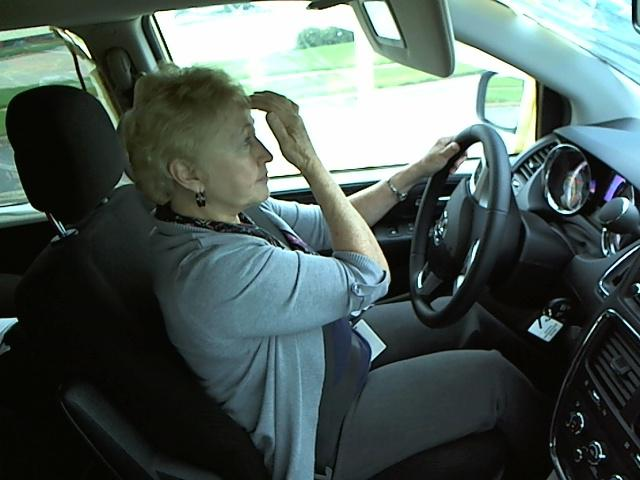

In [ ]:
from __future__ import division
import torch
torch.manual_seed(0)
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image, ImageOps, ImageEnhance
import cv2
from google.colab.patches import cv2_imshow


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

model=torch.load('/content/gdrive/MyDrive/STF/dummy_save_finetune/model 99.98.pth')  # Load pretrained parameters
model.eval()  # Set to eval mode to change behavior of Dropout, BatchNorm

predictions=["safe driving","texting - right","talking on the phone - right","texting - left","talking on the phone - left","operating the radio","drinking",
"reaching behind","hair and makeup", "talking to passenger"]

path="/content/gdrive/MyDrive/STF/test1/c8/img_100015.jpg"

img = Image.open(path)  # Load image as PIL.Image
image=cv2.imread(path)
x = transform(img)  # Preprocess image
x = x.unsqueeze(0)  # Add batch dimension

output = model(x)  # Forward pass
pred = torch.argmax(output, 1)  # Get predicted class if multi-class classification
print('Image predicted as ', predictions[pred[0]])
window=predictions[pred[0]]
cv2_imshow(image)

In [19]:
from __future__ import division
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

# Define transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    #transforms.RandomCrop(224, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the pre-trained model
model = torch.load('/content/drive/MyDrive/STF/dummy_save_finetune/model 99.98.pth')
model.eval()

# List of class labels
predictions = ["safe driving", "texting - right", "talking on the phone - right",
               "texting - left", "talking on the phone - left", "operating the radio",
               "drinking", "reaching behind", "hair and makeup", "talking to passenger"]

# Open the video capture
cap = cv2.VideoCapture('/content/gdrive/MyDrive/STF/endtest/input_video.mp4')
writer = None
(W, H) = (None, None)
while True:
    ret, frame = cap.read()

    if not ret:
        break
	# if the frame dimensions are empty, grab them
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    # Convert the frame to PIL.Image for preprocessing
    pil_frame = Image.fromarray(frame)
    print("hi")
    x = transform(pil_frame)
    x = x.unsqueeze(0)
    output=frame.copy()
    # Perform inference
    with torch.no_grad():
        output = model(x)
    pred = torch.argmax(output, 1)
    label = predictions[pred[0]]
    text = "activity: {}".format(label)
    cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
		1.25, (0, 255, 0), 5)
	# check if the video writer is None
    if writer is None:
		# initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter("/content/drive/MyDrive/STF/endtest/output_video.mp4", fourcc, 30,
            (W, H), True)
    # write the output frame to disk
    writer.write(output)
    # show the output image
    cv2_imshow("Output", output)
    key = cv2.waitKey(1) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
# release the file pointers
print("[INFO] cleaning up...")
#writer.release()
cap.release()
    # Add predicted class text overlay to the frame



[INFO] cleaning up...


In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, predicted_class, (10, 30), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Display the frame with overlay
    cv2_imshow(frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close windows
cap.release()
cv2.destroyAllWindows()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
from __future__ import division
import torch
import torchvision.transforms as transforms
import cv2
from google.colab.patches import cv2_imshow

# Define transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the pre-trained model
model = torch.load('/content/drive/MyDrive/STF/dummy_save_finetune/model 99.98.pth')
model.eval()

# List of class labels
predictions = ["safe driving", "texting - right", "talking on the phone - right",
               "texting - left", "talking on the phone - left", "operating the radio",
               "drinking", "reaching behind", "hair and makeup", "talking to passenger"]

# Open the video capture
cap = cv2.VideoCapture('/content/gdrive/MyDrive/STF/endtest/input_video.mp4')

while True:
    ret, frame = cap.read()

    if not ret:
        break

    # Convert the frame to PIL.Image for preprocessing
    pil_frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    x = transform(pil_frame)
    x = x.unsqueeze(0)

    # Perform inference
    with torch.no_grad():
        output = model(x)
    pred = torch.argmax(output, 1)
    predicted_class = predictions[pred[0]]

    # Add predicted class text overlay to the frame
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, predicted_class, (10, 30), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Display the frame with overlay
    cv2_imshow(frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close windows
cap.release()
cv2.destroyAllWindows()


In [ ]:
# import the necessary packages
from collections import deque
import numpy as np
import argparse
import pickle
import cv2
from driver_prediction import predict_result
# construct the argument parser and parse the arguments


# ap = argparse.ArgumentParser()
# ap.add_argument("-m", "--model", required=True,
# 	help="path to trained serialized model")
# ap.add_argument("-l", "--label-bin", required=True,
# 	help="path to  label binarizer")
# ap.add_argument("-i", "--input", required=True,
# 	help="path to our input video")
# ap.add_argument("-o", "--output", required=True,
# 	help="path to our output video")
# ap.add_argument("-s", "--size", type=int, default=128,
# 	help="size of queue for averaging")
# args = vars(ap.parse_args())

# with open(os.path.join(os.getcwd(),"pickle_files","labels_list.pkl"),"rb") as handle:
#     lb = pickle.loads(handle)

# initialize the image mean for mean subtraction along with the
# predictions queue
# mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
# Q = deque(maxlen=128)
INPUT_VIDEO_FILE = "input_video.mp4"
OUTPUT_VIDEO_FILE = "/content/drive/MyDrive/STF/endtest/output_video.mp4"
# initialize the video stream, pointer to output video file, and
# frame dimensions
vs = cv2.VideoCapture(INPUT_VIDEO_FILE)
writer = None
(W, H) = (None, None)
# loop over frames from the video file stream
while True:
	# read the next frame from the file
	(grabbed, frame) = vs.read()
	# if the frame was not grabbed, then we have reached the end
	# of the stream
	if not grabbed:
		break
	# if the frame dimensions are empty, grab them
	if W is None or H is None:
		(H, W) = frame.shape[:2]
	# clone the output frame, then convert it from BGR to RGB
	# ordering, resize the frame to a fixed 224x224, and then
	# perform mean subtraction
	output = frame.copy()
	frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
	frame = cv2.resize(frame, (128, 128))
	# frame -= mean
	frame = np.expand_dims(frame,axis=0).astype('float32')/255 - 0.5

	# make predictions on the frame and then update the predictions
	# queue
	label = predict_result(frame)
	# preds = model.predict(np.expand_dims(frame, axis=0))[0]
	# Q.append(preds)

	# perform prediction averaging over the current history of
	# previous predictions
	# results = np.array(Q).mean(axis=0)
	# i = np.argmax(results)
	# label = lb.classes_[i]

		# draw the activity on the output frame
	text = "activity: {}".format(label)
	cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
		1.25, (0, 255, 0), 5)
	# check if the video writer is None
	if writer is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(OUTPUT_VIDEO_FILE, fourcc, 30,
			(W, H), True)
	# write the output frame to disk
	writer.write(output)
	# show the output image
	cv2.imshow("Output", output)
	key = cv2.waitKey(1) & 0xFF
	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break
# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()





# lb = pickle.loads(open(args["label_bin"], "rb").read())

Image predicted as  talking on the phone - right


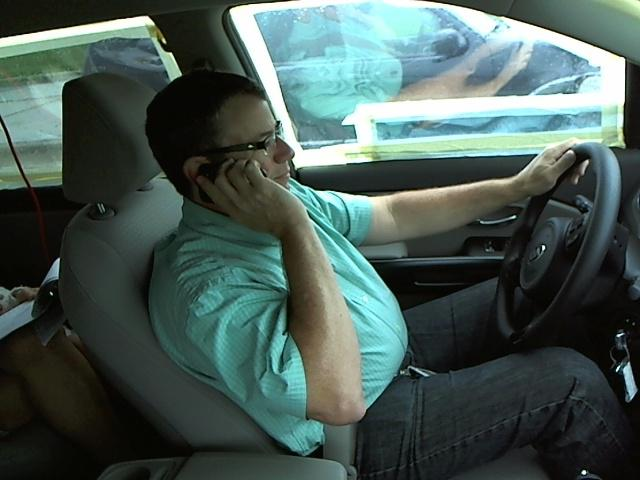

AttributeError: ignored

In [ ]:
from __future__ import division
import torch
torch.manual_seed(0)
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image, ImageOps, ImageEnhance
import cv2
from google.colab.patches import cv2_imshow


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

model=torch.load('/content/gdrive/MyDrive/STF/dummy_save_finetune/model 99.98.pth')  # Load pretrained parameters
model.eval()  # Set to eval mode to change behavior of Dropout, BatchNorm

predictions=["safe driving","texting - right","talking on the phone - right","texting - left","talking on the phone - left","operating the radio","drinking",
"reaching behind","hair and makeup", "talking to passenger"]

path="/content/gdrive/MyDrive/STF/test1/c2/img_100029.jpg"

img = Image.open(path)  # Load image as PIL.Image
image=cv2.imread(path)
x = transform(img)  # Preprocess image
x = x.unsqueeze(0)  # Add batch dimension

output = model(x)  # Forward pass
pred = torch.argmax(output, 1)  # Get predicted class if multi-class classification
print('Image predicted as ', predictions[pred[0]])
window=predictions[pred[0]]
cv2_imshow(image)

cap = cv2.VideoCapture('/content/gdrive/MyDrive/STF/endtest/input_video.mp4')
while(True):
    # Capture frames in the video
    ret, frame = cap.read()

    # describe the type of font
    # to be used.
    img = Image.open(frame,'r')  # Load image as PIL.Image
    #image=cv2.imread(path)
    x = transform(frame)  # Preprocess image
    x = x.unsqueeze(0)  # Add batch dimension

    output = model(x)  # Forward pass
    pred = torch.argmax(output, 1)  # Get predicted class if multi-class classification
    print('Image predicted as ', predictions[pred[0]])
    window=predictions[pred[0]]
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Use putText() method for
    # inserting text on video
    cv2.putText(frame,
                'TEXT ON VIDEO',
                (50, 50),
                font, 1,
                (123, 155, 255),
                2,
                cv2.LINE_4)

    # Display the resulting frame
    cv2_imshow('video', frame)

    # creating 'q' as the quit
    # button for the video
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release the cap object
cap.release()
# close all windows
cv2.destroyAllWindows()